<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [40]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [41]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [42]:
df.shape

(8192, 2)

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [47]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
train['close']

(6553, 2) (1639, 2)


0      -1.516118
1      -1.513027
2      -1.513578
3      -1.506029
4      -1.520001
          ...   
6548    0.904583
6549    0.870288
6550    0.956445
6551    0.962244
6552    0.986881
Name: close, Length: 6553, dtype: float64

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [49]:
train['close']

0      -1.516118
1      -1.513027
2      -1.513578
3      -1.506029
4      -1.520001
          ...   
6548    0.904583
6549    0.870288
6550    0.956445
6551    0.962244
6552    0.986881
Name: close, Length: 6553, dtype: float64

## Task 4: Create Training and Test Splits

In [50]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [51]:
time_steps = 30

x_train, y_train = create_sequences(train[['close']], train.close, time_steps)
x_test, y_test = create_sequences(test[['close']], test.close, time_steps)

In [52]:
x_train.shape

(6523, 30, 1)

## Task 5: Build an LSTM Autoencoder

In [53]:
time_steps = x_train.shape[1]
num_features = x_train.shape[2]

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(time_steps, num_features)),
    Dropout(0.2),
    RepeatVector(time_steps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])

model.compile(optimizer='adam', 
             loss = 'mae',
             metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [55]:
history = model.fit(
    x_train, y_train, epochs=100, batch_size=32,
    validation_split=0.1,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
    shuffle=False
)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 22s 4ms/sample - loss: 0.1625 - accuracy: 0.0000e+00 - val_loss: 0.1610 - val_accuracy: 0.0000e+00
Epoch 2/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.1114 - accuracy: 0.0000e+00 - val_loss: 0.0986 - val_accuracy: 0.0000e+00
Epoch 3/100
5870/5870 [==============================] - 19s 3ms/sample - loss: 0.0903 - accuracy: 0.0000e+00 - val_loss: 0.0443 - val_accuracy: 0.0000e+00
Epoch 4/100
5870/5870 [==============================] - 17s 3ms/sample - loss: 0.0802 - accuracy: 0.0000e+00 - val_loss: 0.0442 - val_accuracy: 0.0000e+00
Epoch 5/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0717 - accuracy: 0.0000e+00 - val_loss: 0.0618 - val_accuracy: 0.0000e+00
Epoch 6/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0774 - accuracy: 0.0000e+00 - val_loss: 0.0326 - val_accuracy: 0.0000e+00
Epoch 7/100
5870/

## Task 7: Plot Metrics and Evaluate the Model

In [63]:
prediction_train = model.predict(x_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(prediction_train - x_train), axis=1), columns=['Error'])

In [64]:
model.evaluate(x_test, y_test)

1609/1609 [==============================] - 2s 1ms/sample - loss: 0.2708 - accuracy: 0.0000e+00


[0.270815260740746, 0.0]

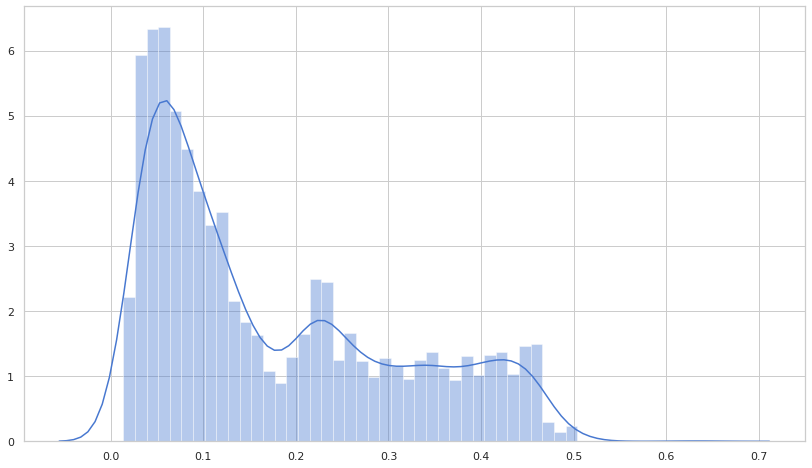

In [65]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [66]:
threshold = 0.65

In [69]:
prediction_test = model.predict(x_test)
test_mae_loss = np.mean(np.abs(prediction_test - x_test), axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [71]:
test_score_df = pd. DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [72]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.094082,0.65,False
6584,2012-02-09,1.221625,0.093309,0.65,False
6585,2012-02-10,1.199313,0.091045,0.65,False
6586,2012-02-13,1.221194,0.073555,0.65,False
6587,2012-02-14,1.218150,0.075310,0.65,False


In [73]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.646861,0.65,False
8188,2018-06-26,4.507583,0.699449,0.65,True
8189,2018-06-27,4.451431,0.704458,0.65,True
8190,2018-06-28,4.491406,0.735130,0.65,True
8191,2018-06-29,4.496343,0.717321,0.65,True


In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()
              

In [79]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.655632,0.65,True
7475,2015-08-26,2.632149,0.711593,0.65,True
8090,2018-02-05,4.329949,0.665444,0.65,True
8091,2018-02-06,4.440671,0.853328,0.65,True
8092,2018-02-07,4.408365,0.829433,0.65,True


In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
              mode='lines', name='Close price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                        mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()